In [3]:
! pip install -r requirements.txt --no-input
! conda install -c conda-forge -y cudatoolkit=11.2 cudnn=8.1.0
! pip install --upgrade pip
! pip install "tensorflow<2.11" 

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... done

## Package Plan ##

  environment location: c:\Users\nxcle\anaconda3\envs\spartan

  added / updated specs:
    - cudatoolkit=11.2
    - cudnn=8.1.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.11.17 |       h56e8100_0         151 KB  conda-forge
    certifi-2023.11.17         |     pyhd8ed1ab_0         155 KB  conda-forge
    cudatoolkit-11.2.2         |      h933977f_10       879.9 MB  conda-forge
    cudnn-8.1.0.77             |       h3e0f4f4_0       610.8 MB  conda-forge
    ------------------------------------------------------------
                                           Total:        1.46 GB

The following NEW packages will be INSTALLED:

  cudatoolkit        conda-forge/win-64::cudatoolkit-11.2.2-h933977f_10
  c



==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c defaults conda




   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
    --------------------------------------- 0.0/2.1 MB 660.6 kB/s eta 0:00:04
   ----- ---------------------------------- 0.3/2.1 MB 3.8 MB/s eta 0:00:01
   ------------- -------------------------- 0.7/2.1 MB 5.6 MB/s eta 0:00:01
   ---------------------- ----------------- 1.2/2.1 MB 6.9 MB/s eta 0:00:01
   -------------------------------- ------- 1.7/2.1 MB 7.8 MB/s eta 0:00:01
   ------------------------------------ --- 1.9/2.1 MB 8.2 MB/s eta 0:00:01
   ---------------------------------------  2.1/2.1 MB 7.4 MB/s eta 0:00:01
   ---------------------------------------- 2.1/2.1 MB 6.1 MB/s eta 0:00:00


ERROR: To modify pip, please run the following command:
c:\Users\nxcle\anaconda3\envs\spartan\python.exe -m pip install --upgrade pip
The system cannot find the file specified.


In [1]:
from train_tf import *
from tensorflow.keras.callbacks import TensorBoard
from parameters import *
import socket
import tensorflow as tf

import datetime
import os

In [2]:

par = get_main_experiments(7, train_gpu=True, tensorboard=True)
par.enc.opt_model_type = OptModelType.OPT_125m
par.enc.news_source = NewsSource.NEWS_SINGLE

# Training args
par.train.use_tf_models = True
par.train.l1_ratio = [0.5]
par.train.batch_size = 128
par.train.monitor_metric = 'val_auc'
par.train.patience = 3
par.train.max_epoch = 3
par.train.abny = False

# par.train.T_train = 1


# Skip Normalisation
# par.train.norm = None

start = time.time()

temp_save_dir = par.get_res_dir()
print(temp_save_dir, flush=True)
already_processed = os.listdir(temp_save_dir)
save_name = f'{par.grid.year_id}.p'
print('save_name', save_name, "already_processed", already_processed)
if save_name in already_processed:
    print(f'Already processed {save_name}', flush=True)
else:
    trainer = PipelineTrainer(par)
    trainer.def_create_the_datasets(
        filter_func=lambda x: 'mean' in x.split('/')[-1].split('_'),  # filter by 'mean' in file name
    )
    print('Preprocessing time', np.round((time.time() - start) / 60, 5), 'min', flush=True)


START WORKING ON  7
comb 8 / 264
/data/gpfs/projects/punim2119/EightK/res/temp/vec_pred/d7cc8fc49ceec47bf5ac309008d70a2ed2e1e7df992a46af4c24ecdaf9a71c85/OPT_125m/NEWS_SINGLE/
save_name 2019.p already_processed []
tensorboard --logdir=C:\Users\nxcle\repo\EightK\logs\fit\20240129-234353
Preprocessing time 0.01687 min


In [3]:
model = trainer.train_model(tr_data=trainer.train_val_dataset, val_data=None, reg_to_use=tf.keras.regularizers.l1_l2(0.001, 0.001))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 768)              1537      
 n)                                                              
                                                                 
 dense (Dense)               (None, 1)                 769       
                                                                 
Total params: 2,306
Trainable params: 769
Non-trainable params: 1,537
_________________________________________________________________
Epoch 1/3
29899/29899 [==============================] - 728s 24ms/step - loss: 0.6944 - accuracy: 0.5407 - auc: 0.5502 - precision: 0.5510 - recall: 0.6810
Epoch 2/3
29899/29899 [==============================] - 703s 24ms/step - loss: 0.6929 - accuracy: 0.5410 - auc: 0.5506 - precision: 0.5510 - recall: 0.6834
Epoch 3/3
29899/29899 [==============================] - 727s 24ms/s

In [ ]:
model1_evaluation_results_val = model.evaluate(
    trainer.val_dataset,
    return_dict=True
)
model1_evaluation_results_val

In [5]:
model1_evaluation_results_test = model.evaluate(
    trainer.test_dataset,
    return_dict=True
)
model1_evaluation_results_test

4304/4304 [==============================] - 148s 20ms/step - loss: 0.7146 - accuracy: 0.5377 - auc: 0.4950 - precision_1: 0.5419 - recall_1: 0.9417


{'loss': 0.7146130204200745,
 'accuracy': 0.5377008318901062,
 'auc': 0.49495214223861694,
 'precision_1': 0.5419256687164307,
 'recall_1': 0.9417335391044617}

In [4]:
trainer.model = model
df = trainer.get_prediction_on_test_sample()
df.to_pickle(temp_save_dir + save_name)
par.save(temp_save_dir)

4304/4304 [==============================] - 87s 4ms/step
Accuracy from .df: 0.529466


## Results

In [10]:

from data import *
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import swifter
from tqdm import tqdm
import regex as re

C:\Users\nxcle\anaconda3\envs\spartan\lib\site-packages\dask\dataframe\_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [5]:
args = didi.parse()
par = Params()
data = Data(par)

# load_dir = '/data/gpfs/projects/punim2119/EightK/res/temp/vec_pred/5e8b285d69edeee2833f1f2aa4d81ef00f787ed5188fcf557a54d04ad73af547/OPT_125m/NEWS_SINGLE/' # No Normalisation, Ret
# load_dir = '/data/gpfs/projects/punim2119/EightK/res/temp/vec_pred/23c308fffeb08a56e3eb4b0717303816005bafc70a823f1a45b92c2c9027ab88/OPT_125m/NEWS_SINGLE/' # No Normalisation, Abret
load_dir = '/data/gpfs/projects/punim2119/EightK/res/temp/vec_pred/d7cc8fc49ceec47bf5ac309008d70a2ed2e1e7df992a46af4c24ecdaf9a71c85/OPT_125m/NEWS_SINGLE/' # Normalisation, Ret


model_outputs = [os.path.join(load_dir, f) for f in os.listdir(load_dir) if re.match(r'\d+.p$', f)]
model_outputs

['/data/gpfs/projects/punim2119/EightK/res/temp/vec_pred/d7cc8fc49ceec47bf5ac309008d70a2ed2e1e7df992a46af4c24ecdaf9a71c85/OPT_125m/NEWS_SINGLE/2019.p']

In [6]:
crsp = data.load_crsp_daily()
crsp_sorted = crsp.sort_values(by=['permno', 'date'])
crsp_sorted.head(10)

,permno,date,ticker,prc,ret,bid,ask,shrout
0,10001,1993-01-04,GFGC,14.50,0.035714,14.00,14.50,1080.0
1,10001,1993-01-05,GFGC,-14.25,-0.017241,14.00,14.50,1080.0
2,10001,1993-01-06,GFGC,-14.25,0.000000,14.00,14.50,1080.0
3,10001,1993-01-07,GFGC,14.50,0.017544,14.00,14.50,1080.0
4,10001,1993-01-08,GFGC,14.50,0.000000,14.00,14.50,1080.0
5,10001,1993-01-11,GFGC,14.50,0.000000,14.00,14.50,1080.0
6,10001,1993-01-12,GFGC,-14.25,-0.017241,14.00,14.50,1080.0
7,10001,1993-01-13,GFGC,13.75,-0.035088,13.75,14.25,1080.0
8,10001,1993-01-14,GFGC,13.75,0.000000,13.75,14.25,1080.0
9,10001,1993-01-15,GFGC,-14.00,0.018182,13.75,14.25,1080.0


In [7]:
# read df from pickle
#date should be in datetime64[ns]
df = pd.read_pickle(model_outputs[0]).rename(columns={'ticker':'permno'})
df['date'] = pd.to_datetime(df['date'])
df.rename(columns={'date': 'date_news'}, inplace=True)
df

,id,date_news,permno,y_true,y_pred,y_pred_prb,accuracy
0,APN003RW8_19030419KKbgxzjEsZU97w8+QLlkLLmQcWbS...,2019-03-04,13928,1,1,0.547121,True
1,APN003RW8_1903042PBBhDz3eWUK1mUFX83o0MfkCcZTiJ...,2019-03-04,13928,1,1,0.652843,True
2,APN00001Z_1903052vUuZe1H/yDMlkTk6z3NnAOwP67S4f...,2019-03-05,25785,0,0,0.497510,True
3,A5N20D00C_1903051PbdzJf8U29nnxcOY+Hmb7zeZPLjjz...,2019-03-05,11850,0,1,0.528784,False
4,A5N20D00C_1903052/EdmDbsLU1q0g3iawPMuJPcqFDs12...,2019-03-05,11850,0,0,0.489575,True
...,...,...,...,...,...,...,...
550818,GNX1KJSjR_1904302u1Eqj8eMe+u+qTRXNBVqIPH0yrNcR...,2019-04-30,18397,1,1,0.540604,True
550819,GNE4wH4vk_1904302utC01nS8KCeukGVa80HD2Xt2mV9A7...,2019-04-30,93089,1,1,0.599444,True
550820,GNE9jqCZN_1904302m3V+3dlGiYreBpg80QhQLCb99DRi4...,2019-04-30,81677,1,1,0.530702,True
550821,CNW57M0ra_1904302aT1T5CW6OFbwbnKhKB21fcZ1j61ON...,2019-04-30,81527,1,1,0.530396,True


In [8]:
df['accuracy'].mean()

0.5294659082863279

In [11]:
n_days_ahead = 1

print('Creating permno mapping')
crsp_grouped = crsp_sorted.groupby('permno')
permno_mapping = {}
permno_date_to_index_mapping = {}  # New mapping for date to index

for permno, group in tqdm(crsp_grouped):
    records = group[['date', 'prc', 'ret', 'bid', 'ask', 'shrout']].to_records(index=False)
    permno_mapping[permno] = records
    permno_date_to_index_mapping[permno] = {date: idx for idx, date in enumerate(group['date'])}


Creating permno mapping


100%|██████████| 14658/14658 [00:50<00:00, 289.03it/s]


In [12]:
# Function to perform binary search and get nth day return
def get_nth_day_return(row):
    permno = row['permno']
    date_news = row['date_news']

    trading_days = permno_mapping.get(permno, None)
    date_to_index = permno_date_to_index_mapping.get(permno, {})

    if trading_days is not None and date_news in date_to_index:
        start_index = date_to_index[date_news]
        nth_index = start_index + n_days_ahead

        if nth_index < len(trading_days):
            nth_day_data = trading_days[nth_index]
            return pd.Series({
                'date': nth_day_data.date,
                'prc': nth_day_data.prc,
                'ret': nth_day_data.ret,
                'bid': nth_day_data.bid,
                'ask': nth_day_data.ask,
                'shrout': nth_day_data.shrout
            })
    # Return default values if conditions are not met
    return pd.Series({
        'date': pd.NaT,
        'prc': None,
        'ret': None,
        'bid': None,
        'ask': None,
        'shrout': None
    })

tqdm.pandas(desc="Processing rows")
additional_columns = df.progress_apply(get_nth_day_return, axis=1)
for col in ['prc', 'ret', 'bid', 'ask', 'shrout']:
    additional_columns[col] = pd.to_numeric(additional_columns[col], errors='coerce')
df_merged = pd.concat([df, additional_columns], axis=1)
df_merged.rename(columns={'date': 'date_trade'}, inplace=True)
df_merged

Processing rows: 100%|██████████| 550823/550823 [01:10<00:00, 7806.33it/s] 


,id,date_news,permno,y_true,y_pred,y_pred_prb,accuracy,date_trade,prc,ret,bid,ask,shrout
0,APN003RW8_19030419KKbgxzjEsZU97w8+QLlkLLmQcWbS...,2019-03-04,13928,1,1,0.547121,True,2019-03-05,69.01,-0.012732,69.00,69.01,1134404.0
1,APN003RW8_1903042PBBhDz3eWUK1mUFX83o0MfkCcZTiJ...,2019-03-04,13928,1,1,0.652843,True,2019-03-05,69.01,-0.012732,69.00,69.01,1134404.0
2,APN00001Z_1903052vUuZe1H/yDMlkTk6z3NnAOwP67S4f...,2019-03-05,25785,0,0,0.497510,True,2019-03-06,8.58,-0.021665,8.58,8.59,3907700.0
3,A5N20D00C_1903051PbdzJf8U29nnxcOY+Hmb7zeZPLjjz...,2019-03-05,11850,0,1,0.528784,False,2019-03-06,79.28,-0.011348,79.26,79.27,4237000.0
4,A5N20D00C_1903052/EdmDbsLU1q0g3iawPMuJPcqFDs12...,2019-03-05,11850,0,0,0.489575,True,2019-03-06,79.28,-0.011348,79.26,79.27,4237000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
550818,GNX1KJSjR_1904302u1Eqj8eMe+u+qTRXNBVqIPH0yrNcR...,2019-04-30,18397,1,1,0.540604,True,2019-05-01,13.64,0.000734,13.59,13.85,17067.0
550819,GNE4wH4vk_1904302utC01nS8KCeukGVa80HD2Xt2mV9A7...,2019-04-30,93089,1,1,0.599444,True,2019-05-01,139.88,-0.008927,139.81,139.87,163666.0
550820,GNE9jqCZN_1904302m3V+3dlGiYreBpg80QhQLCb99DRi4...,2019-04-30,81677,1,1,0.530702,True,2019-05-01,75.11,0.014041,75.10,75.11,162818.0
550821,CNW57M0ra_1904302aT1T5CW6OFbwbnKhKB21fcZ1j61ON...,2019-04-30,81527,1,1,0.530396,True,2019-05-01,2.05,-0.023810,2.04,2.05,71896.0


In [13]:
df_grouped =df_merged.groupby(['permno','date_news'])[['ret','y_pred_prb','y_true', 'prc']].mean().reset_index()

df_grouped['year'] = df_grouped['date_news'].dt.year
print(df_grouped.groupby('year')['y_pred_prb'].mean())
df_grouped['tresh'] = df_grouped.groupby('year')['y_pred_prb'].transform('mean')

year
2019    0.537318
Name: y_pred_prb, dtype: float32


In [14]:
df_grouped['pred'] = df_grouped['y_pred_prb']>df_grouped['tresh']
# df_grouped['pred'] = df_grouped['y_pred_prb']>0.5
df_grouped['accuracy']=df_grouped['pred']==df_grouped['y_true']
df_grouped['accuracy'].mean()

0.5055311464687398

In [15]:
df_merged['accuracy'].mean()

0.5294659082863279

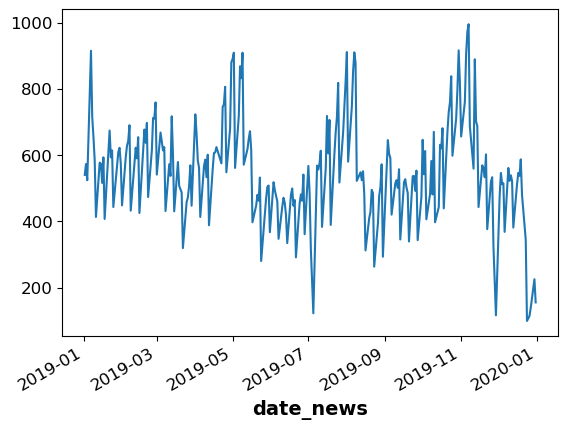

In [16]:

df_grouped.groupby('date_news')['permno'].count().plot()
df_grouped['pct']=df_grouped.groupby('date_news')['y_pred_prb'].rank(pct=True)

In [17]:
df_grouped

,permno,date_news,ret,y_pred_prb,y_true,prc,year,tresh,pred,accuracy,pct
0,10026,2019-01-16,0.013348,0.495881,0.0,145.75999,2019,0.537318,False,True,0.155039
1,10026,2019-01-28,0.120143,0.541280,0.0,156.82001,2019,0.537318,True,False,0.553004
2,10026,2019-01-29,-0.040301,0.521560,1.0,150.50000,2019,0.537318,False,False,0.348112
3,10026,2019-01-31,0.002915,0.587164,1.0,154.80000,2019,0.537318,True,True,0.831010
4,10026,2019-02-06,-0.011565,0.492951,0.0,156.41000,2019,0.537318,False,True,0.175739
...,...,...,...,...,...,...,...,...,...,...,...
140653,93436,2019-12-24,0.013380,0.525814,1.0,430.94000,2019,0.537318,False,False,0.393939
140654,93436,2019-12-26,-0.001299,0.564038,1.0,430.38000,2019,0.537318,True,True,0.675439
140655,93436,2019-12-27,-0.036433,0.509514,0.0,414.70001,2019,0.537318,False,True,0.181159
140656,93436,2019-12-30,0.008753,0.546904,0.0,418.32999,2019,0.537318,True,False,0.488889


In [18]:
confusion_matrix(df_grouped['y_true'], df_grouped['pred'])

array([[28786, 35935],
       [33616, 42321]], dtype=int64)

<Axes: xlabel='date_news'>

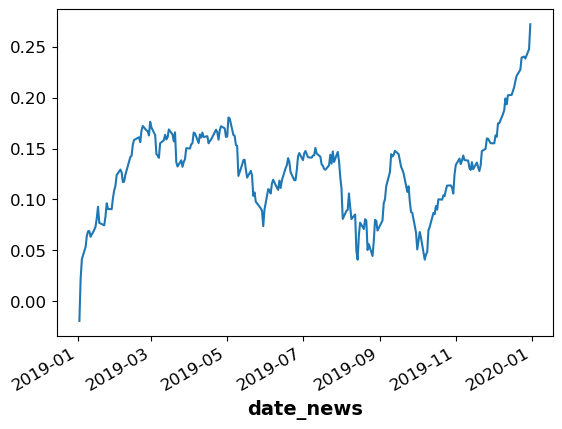

In [19]:
df_grouped.groupby(['date_news'])['ret'].mean().cumsum().plot()

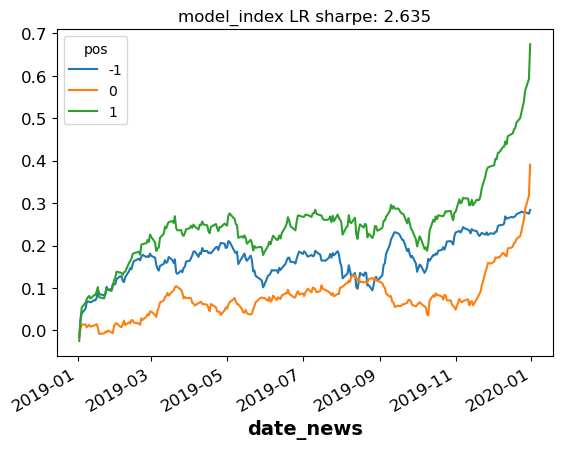

In [20]:
tresh = 0.2
df_grouped['pos'] = 1*(df_grouped['pct']>(1-tresh)) - (df_grouped['pct']<=tresh)*1
ret=df_grouped.groupby(['date_news','pos'])['ret'].mean().reset_index().pivot(columns='pos',index='date_news',values='ret')
ret[0] = ret[1]-ret[-1]
ret.cumsum().plot()
sh = np.sqrt(252)*(ret.mean()/ret.std()).round(3)
plt.title(f'model_index {"LR"} sharpe: {np.round(sh[0],3)}')
plt.show()

In [21]:
# index ret by [1, -1, 0]
ret_formated = ret[[1, -1, 0]]
sh_formated = np.sqrt(252)*(ret_formated.mean()/ret_formated.std()).round(3)
print("        ", "Long", "Short", "L-S", sep="\t")
print("Return: ", *list((252 * ret_formated.mean()).round(3)), sep="\t")
print("Std:    ", *list((np.sqrt(252)*ret_formated.std()).round(3)), sep="\t")
print("Sharpe: ", *list(sh_formated.round(3)), sep="\t")

        	Long	Short	L-S
Return: 	0.674	0.284	0.39
Std:    	0.208	0.161	0.148
Sharpe: 	3.238	1.762	2.635
